In [2]:
cd ..

c:\Users\Lenovo\Desktop\Deep_Learning_with_Python\Facial_Key_Point_Training


C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Import Packages
#Inbuilt packages
import os
from PIL import Image
from tqdm import tqdm
#Datascience packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Pytorch related Packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models



# Hyperparameters

In [3]:
# HyperParameter
batch_size = 16
model_input_size = 224
n_epoch = 5
learning_rate = 0.0001


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loader

In [5]:
# Data Loader

class FaceKeyPointData(Dataset):
    def __init__(self, csv_path = 'data/training_frames_keypoints.csv', split = 'training',device= device):
        super(FaceKeyPointData).__init__()
        self.csv_path = csv_path
        self.split = split
        self.df = pd.read_csv(self.csv_path)
        # print(self.df)
        self.normalize = transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
        self.device = device 

    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img,original_size = self.get_img(index)
        key_points = self.get_keypoints(index,original_size)
        return img,key_points

    def get_img(self,index):
        img_path = os.path.join(os.getcwd(),'data',self.split, self.df.iloc[index, 0]) #select the image path using index
        # print(img_path)
        img = Image.open(img_path).convert('RGB') 
        original_size = img.size
        # print(original_size)

        #preprocess the image
        img = img.resize((model_input_size, model_input_size))  #VGG sanga use garna
        img = np.asarray(img)/255.0               #pixel value normalization i.e. normalize pixel values to be between 0 and 1
        img = torch.tensor(img).permute(2,0,1)  # transpose 
        img = self.normalize(img).float()     #normalize using transforms.normalize to have mean = 0 and sd =1
        # print(img)
        return img.to(self.device), original_size
    
    def get_keypoints(self,index,original_size):
        kp = self.df.iloc[index, 1:].to_numpy().astype(np.float32)
        kp_x = np.array(kp[0::2]) / original_size[0]
        kp_y = np.array(kp[1::2]) / original_size[1]
        kp = np.concatenate((kp_x, kp_y))
        return torch.tensor(kp).to(self.device)
    
    def load_img(self, index):
        img_path = os.path.join(os.getcwd(),'data',self.split, self.df.iloc[index, 0]) #select the image path using index
        img = Image.open(img_path).convert('RGB') 
        img = img.resize((model_input_size, model_input_size)) 
        img = np.asarray(img)/255.0 
        return img





training_data = FaceKeyPointData(device=device)
test_data = FaceKeyPointData(csv_path='data/test_frames_keypoints.csv',split = 'test',device = device)

In [6]:
train_dataloader = DataLoader(training_data, batch_size= batch_size, shuffle= True)
test_dataloader = DataLoader(test_data, batch_size= batch_size, shuffle= False)


In [7]:
batch_img, batch_keyp= next(iter(train_dataloader))
print(batch_img.shape)

torch.Size([16, 3, 224, 224])


In [8]:
batch_keyp.shape

torch.Size([16, 136])

# Visualization

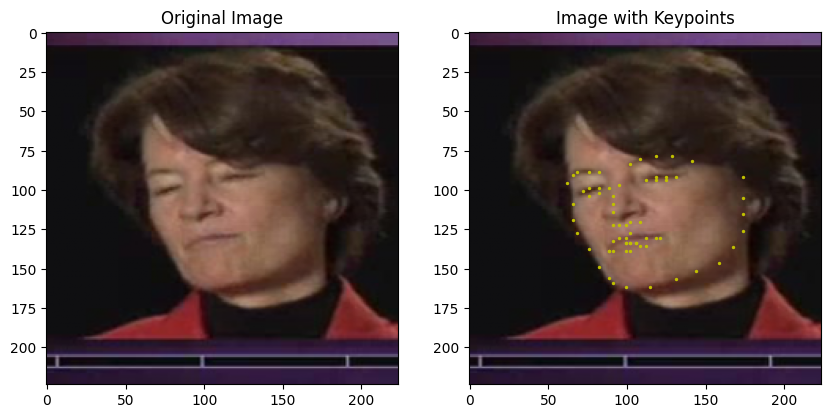

In [9]:
img_index = 22
img = training_data.load_img(img_index)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(122)
plt.title('Image with Keypoints')
plt.imshow(img)

img_tensor, kp_s = training_data[img_index]
kp_x = kp_s[:68].cpu() * model_input_size
kp_y = kp_s[68:].cpu() * model_input_size
plt.scatter(kp_x, kp_y , c = 'y', s = 2)




# Model Building


In [10]:
def get_model(device):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for layers in model.parameters():
        layers.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512,3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    model.classifier = nn.Sequential(
        nn.Linear(2048,512),
        nn.ReLU(inplace=True),
        nn.Dropout(0,5),
        nn.Linear(512,136),
        nn.Sigmoid()
    )
    return model.to(device=device)
model = get_model(device= device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
criterion = nn.L1Loss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [12]:
def train_batch(imgs, kps,model,criterion,optimizer ):
    model.train()
    optimizer.zero_grad()

    #forward pass
    kps_pred = model(imgs)
    loss = criterion(kps_pred,kps)

    #backward pass
    loss.backward()
    optimizer.step()

    return loss

In [13]:
@torch.no_grad()
def validation_batch(imgs, kps,model,criterion ):
    model.eval()

    #forward pass
    kps_pred = model(imgs)
    loss = criterion(kps_pred,kps)

    return loss

# Training Pipeline


In [14]:
train_loss = []
test_loss = []

for epoch in range(1, n_epoch+1):
    epoch_train_loss, epoch_test_loss = 0, 0 

    # train 
    for images, kps in tqdm(train_dataloader, desc=f'Training {epoch} of {n_epoch}'):
        # images, kps = 
        loss = train_batch(images, kps, model, criterion, optimizer)
        epoch_train_loss+= loss.item()
    epoch_train_loss /= len(train_dataloader)
    train_loss.append(epoch_train_loss)
   
    # validation
    for images, kps in tqdm(test_dataloader, desc="validation"):
        loss = validation_batch(images, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= len(test_dataloader)
    test_loss.append(epoch_test_loss)

    print(f"Epoch {epoch} of {n_epoch}: Training Loss: {epoch_train_loss}, Test Loss: {epoch_test_loss}")

validation: 100%|██████████| 49/49 [00:08<00:00,  5.75it/s]


Epoch 1 of 5: Training Loss: 0.03567508986640361, Test Loss: 0.023236575745502298


validation: 100%|██████████| 49/49 [00:08<00:00,  5.56it/s]


Epoch 2 of 5: Training Loss: 0.021021820845142487, Test Loss: 0.019358204677700996


validation: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]


Epoch 3 of 5: Training Loss: 0.015831352014111757, Test Loss: 0.017485644554301183


validation: 100%|██████████| 49/49 [00:08<00:00,  5.57it/s]


Epoch 4 of 5: Training Loss: 0.013282125781414696, Test Loss: 0.016280856002502297


validation: 100%|██████████| 49/49 [00:08<00:00,  5.50it/s]

Epoch 5 of 5: Training Loss: 0.011751589232257434, Test Loss: 0.01580176821776799


# Train and Test Loss Curve


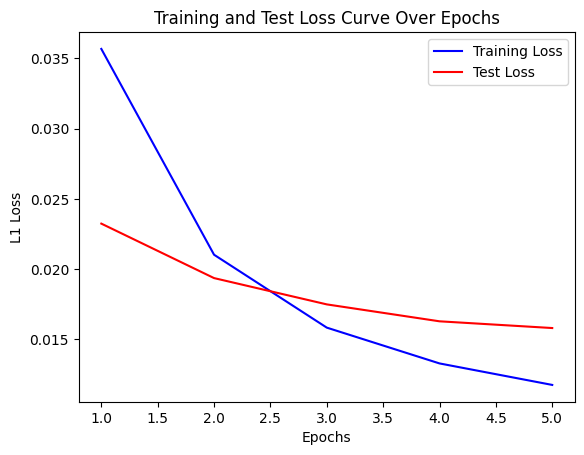

In [17]:
epochs = np.arange(1, n_epoch+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.title("Training and Test Loss Curve Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()
plt.show()

## Result visualization

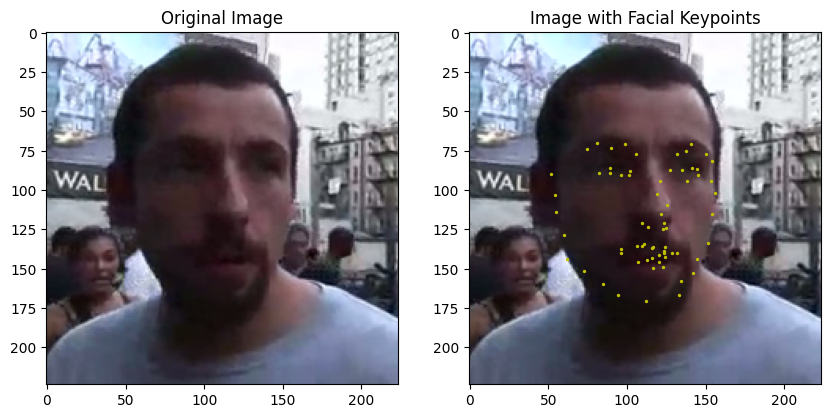

In [18]:
img_index = 11
img = test_data.load_img(img_index)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.imshow(img)

img, _ = test_data[img_index]
kp_s = model(img[None]).flatten().detach().cpu()
kp_s = kp_s.to('cpu')
plt.scatter(kp_s[:68] * model_input_size, kp_s[68:] * model_input_size, c='y',s = 2)